In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
# SoftTouch Lenses complete database
# conn = psycopg2.connect(
#     host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
#     port='5432',
#     user='softtouchlenses_4e0b7c925f8444429457581f35678aea',
#     password='softtouchlenses_4e0b7c925f8444429457581f35678aea_password',
#     database='softtouchlenses_4e0b7c925f8444429457581f35678aea_db'
# )

conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            o.total_price as order_amount,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])
data[data["product_id"] == np.nan]
data = data.dropna()
data['WeekCount']=data['order_date'].dt.strftime('%Y-w%U')
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [6]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [7]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [8]:
Weekly_Stats = {}
productsegstats_weekly = {}
user_cohort_labels = ['New', 'Churned (Single Use Only)', 'Recent & Loyals', 'Champions', 'Churned (Repeat Use)']
user_cohort_var_list = ['Users']#, 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV'
product_cohort_labels=['Hero', 'High Value & Slow Moving', 'Low Value & Slow Moving', 'New Business Drivers', 'Repeat Business Drivers']
product_cohort_var_list=['ProductCount'] #'Orders','Users','AverageSellingPrice','QuantityperCart','CartPenetration','NewUserRatio','NewOrders','ASPXQpC','AOVContribution','ProductCountMix','OrdersMix','UsersMix','AOVContribution(%)','OrderPerSKU'
final_stats = pd.DataFrame()
for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: x.nlargest(2).min()),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          #Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          #Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()
    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    #userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    #userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']
    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    #userweeklydata['f_score'] = userweeklydata['OrdersCount'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
   # userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    #userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    #userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
    def CohortLables_3(df):
      if ((df['Frequency']==1) & (df['r_score']>2)):
          return "New"
      elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
          return 'Churned (Single Use Only)'
      elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
          return 'Recent & Loyals'
      elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
          return 'Champions'
      else:
          return 'Churned (Repeat Use)'
    userweeklydata['User_Cohort_Label'] = userweeklydata.apply(CohortLables_3, axis=1)
    x3=pd.merge(x3,
         userweeklydata[['user_id','User_Cohort_Label']],
         on="user_id",
         how ='left')
    totalcarts=x3['order_id'].nunique()
    product_level=x3.groupby(['product_id']).agg(
            Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
            RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
    produser=data.groupby(['product_id','user_id']).agg(
        New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    produser_newcount=produser.groupby('product_id').agg(
        New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
    ).reset_index()
    data_repeat=data[data['TrxnRank']==2]
    produser_repeatcount=data_repeat.groupby('user_id').agg(
        Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
    k.fillna(0)
    k1=k.groupby('product_id').agg(
        Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
    ).reset_index()
    productlevel=pd.merge(product_level,produser_newcount, on='product_id', how='left')
    productlevel=pd.merge(productlevel,k1,on='product_id',how='left')
    productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
    productlevel=productlevel.sort_values('NewRepeatConversionRatio')
    productlevel['CartPenetration']=productlevel['Carts']/totalcarts
    productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
    productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']
    CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
    productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
    productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
    productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
    productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
    productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
    def ProductCohortLables2(df):
        if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
            return 'Hero'
        elif df['NewRepeatConversion_score'] >2:
            return 'Repeat Business Drivers'
        elif (df['CP_score'] >2):
            return 'New Business Drivers'
        elif (df['ASP_score'] >3):
            return 'High Value & Slow Moving'
        elif (df['ASP_score'] <=3):
            return 'Low Value & Slow Moving'
        else:
            return 'Low Value & Slow Moving'
    productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)
    x3=pd.merge(x3,
         productlevel[['product_id','Product Cohort Lables']],
         on="product_id",
         how ='left')
    User_Product_Level=x3.groupby(['User_Cohort_Label','Product Cohort Lables']).agg(
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique'),
    ).reset_index()
    Weekly_Stats[x] = User_Product_Level
    x4 = data[data['WeekCount']==x]
    x5 = pd.merge(x4,userweeklydata[['user_id','User_Cohort_Label']], on='user_id', how='left')
    x5 = pd.merge(x5,productlevel[['product_id','Product Cohort Lables']], on='product_id', how='left')
    final_stats = final_stats.append(x5, ignore_index=True)
  except:
    pass

In [9]:
final_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405821 entries, 0 to 1405820
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   order_id               1405821 non-null  int64         
 1   order_date             1405821 non-null  datetime64[ns]
 2   user_id                1405821 non-null  float64       
 3   product_id             1405821 non-null  float64       
 4   product_name           1405821 non-null  object        
 5   order_amount           1405821 non-null  float64       
 6   order_status           1405821 non-null  object        
 7   quantity               1405821 non-null  int64         
 8   sp                     1405821 non-null  float64       
 9   WeekCount              1405821 non-null  object        
 10  TrxnRank               1405821 non-null  float64       
 11  New                    1405821 non-null  int64         
 12  Repeat                 14058

In [11]:
final_stats

,order_id,order_date,user_id,product_id,product_name,order_amount,order_status,quantity,sp,WeekCount,TrxnRank,New,Repeat,ordervalue,AOVContribution,DeltaDaysinOrders,DeltaOrderValues,User_Cohort_Label,Product Cohort Lables
0,2424062017674,2020-09-20,3.563140e+12,5.321724e+12,Easy Brew - Cold Brew Bags (Pack of 4),455.0,Delivered,1,650.0,2020-w38,1.0,1,0,650.0,0.010462,NaN,NaN,Churned (Single Use Only),Hero
1,2424320131210,2020-09-20,3.563591e+12,5.321724e+12,Easy Brew - Cold Brew Bags (Pack of 4),455.0,Delivered,1,650.0,2020-w38,1.0,1,0,650.0,0.010462,NaN,NaN,Churned (Repeat Use),Hero
2,2424245485706,2020-09-20,3.563472e+12,5.321724e+12,Easy Brew - Cold Brew Bags (Pack of 4),455.0,Delivered,1,650.0,2020-w38,1.0,1,0,650.0,0.010462,NaN,NaN,Churned (Single Use Only),Hero
3,2424237817994,2020-09-20,3.563460e+12,5.321724e+12,Easy Brew - Cold Brew Bags (Pack of 4),455.0,Delivered,1,650.0,2020-w38,1.0,1,0,650.0,0.010462,NaN,NaN,Churned (Single Use Only),Hero
4,2424183718026,2020-09-20,3.563360e+12,5.321724e+12,Easy Brew - Cold Brew Bags (Pack of 4),455.0,Delivered,1,650.0,2020-w38,1.0,1,0,650.0,0.010462,NaN,NaN,Churned (Repeat Use),Hero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405816,5350985072778,2023-12-15,6.669237e+12,6.624082e+12,Blueberry Mocha - Speciality Blend - 250 gm / ...,630.0,Delivered,1,630.0,2023-w50,3.0,0,1,630.0,0.010140,0.0,0.0,Champions,Hero
1405817,5350985072778,2023-12-15,6.669237e+12,6.624082e+12,Blueberry Mocha - Speciality Blend - 250 gm / ...,630.0,Delivered,1,630.0,2023-w50,3.0,0,1,630.0,0.010140,0.0,0.0,Champions,Hero
1405818,5350985072778,2023-12-15,6.669237e+12,6.624082e+12,Blueberry Mocha - Speciality Blend - 250 gm / ...,630.0,Delivered,1,630.0,2023-w50,3.0,0,1,630.0,0.010140,0.0,0.0,Champions,Low Value & Slow Moving
1405819,5350985072778,2023-12-15,6.669237e+12,6.624082e+12,Blueberry Mocha - Speciality Blend - 250 gm / ...,630.0,Delivered,1,630.0,2023-w50,3.0,0,1,630.0,0.010140,0.0,0.0,Champions,Low Value & Slow Moving


In [12]:
final_stats["User_Cohort_Label"].unique()

array(['Churned (Single Use Only)', 'Churned (Repeat Use)',
       'Recent & Loyals', 'New', 'Champions'], dtype=object)

In [13]:
#AOV Contribution
final_stats['ordervalue']=final_stats['ordervalue']
final_stats['AOVContribution']=final_stats['ordervalue']/final_stats["order_id"].nunique()
final_stats['DeltaDaysinOrders']=(final_stats.groupby('user_id').order_date.shift() - final_stats.order_date).dt.days.abs()
final_stats['DeltaOrderValues']=(final_stats.groupby('user_id').ordervalue.shift() - final_stats.ordervalue)
weekly_summary_stats = final_stats.groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
            totalorders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            totalusers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            totalvalue=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            SKUCounts=pd.NamedAgg(column='product_id', aggfunc='nunique')
      ).reset_index()
newdf=final_stats[final_stats['New']==1].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    newusercount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
     ).reset_index()
cancelled_orders = final_stats[final_stats['order_status'] == 'Cancelled'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()

delivered_orders = final_stats[final_stats['order_status'] == 'Delivered'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()
weekly_summary_stats = weekly_summary_stats.merge(newdf, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats =weekly_summary_stats.merge(cancelled_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats = weekly_summary_stats.merge(delivered_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats['repeatusercount']=weekly_summary_stats['totalusers']-weekly_summary_stats['newusercount']
weekly_summary_stats['AOV'] = weekly_summary_stats['totalvalue']/ weekly_summary_stats['totalorders']


In [14]:
final_stats["Retention"] = 0
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 0) & (final_stats["DeltaDaysinOrders"] <= 90) , "Retention"] = "Retained"
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 90), "Retention"] = "Not-Retained"
retained_df = final_stats[final_stats['Retention'] == 'Retained'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).size().reset_index(name='Retained_Users')
weekly_summary_stats = pd.merge(weekly_summary_stats, retained_df, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883 entries, 0 to 2882
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WeekCount              2883 non-null   object 
 1   User_Cohort_Label      2883 non-null   object 
 2   Product Cohort Lables  2883 non-null   object 
 3   totalorders            2883 non-null   int64  
 4   totalusers             2883 non-null   int64  
 5   totalvalue             2883 non-null   float64
 6   quantity               2883 non-null   int64  
 7   SKUCounts              2883 non-null   int64  
 8   newusercount           1498 non-null   float64
 9   CancellationCount      278 non-null    float64
 10  DeliveryCount          2879 non-null   float64
 11  repeatusercount        1498 non-null   float64
 12  AOV                    2883 non-null   float64
 13  Retained_Users         1036 non-null   float64
dtypes: float64(7), int64(4), object(3)
memory usage: 315.5+ 

In [15]:
key_metrices = ['WeekCount','User_Cohort_Label','Product Cohort Lables','totalorders', 'totalvalue', 'repeatusercount','newusercount', 'AOV']
weekly_summary_stats = weekly_summary_stats[key_metrices]

weekly_summary_stats = weekly_summary_stats.rename(columns={
    'totalorders':'Total_Orders',
    'totalvalue': 'Total_Value',
    'repeatusercount': 'No_of_Repeat_Users',
    'newusercount': 'No_of_New_Users(First_Time_Users)',
    'AOV': 'Average_Order_Value'
})
weekly_summary_stats=weekly_summary_stats.fillna(0)

In [16]:
weekly_summary_stats["User_Cohort_Label"].unique()

array(['Champions', 'Churned (Repeat Use)', 'Churned (Single Use Only)',
       'New', 'Recent & Loyals'], dtype=object)

In [17]:
weekly_summary_stats

,WeekCount,User_Cohort_Label,Product Cohort Lables,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),Average_Order_Value
0,2020-w38,Champions,Hero,25,16250.0,0.0,10.0,650.000000
1,2020-w38,Churned (Repeat Use),Hero,34,22100.0,1.0,13.0,650.000000
2,2020-w38,Churned (Single Use Only),Hero,303,196820.0,0.0,303.0,649.570957
3,2020-w38,Churned (Single Use Only),Low Value & Slow Moving,1,585.0,0.0,1.0,585.000000
4,2020-w38,New,Hero,313,203385.0,0.0,313.0,649.792332
...,...,...,...,...,...,...,...,...
2878,2023-w50,Recent & Loyals,Hero,111,450126.0,84.0,13.0,4055.189189
2879,2023-w50,Recent & Loyals,High Value & Slow Moving,10,107600.0,6.0,2.0,10760.000000
2880,2023-w50,Recent & Loyals,Low Value & Slow Moving,11,167082.0,6.0,3.0,15189.272727
2881,2023-w50,Recent & Loyals,New Business Drivers,93,44535.0,70.0,11.0,478.870968


In [18]:
weekly_summary_stats['AOV_Contribution'] = weekly_summary_stats['Total_Value'] / weekly_summary_stats.groupby('WeekCount')['Total_Orders'].transform('sum')

In [19]:
weekly_summary_stats = weekly_summary_stats.drop("Average_Order_Value", axis=1)

In [20]:
weekly_summary_stats["key"] = weekly_summary_stats["User_Cohort_Label"] + "-" + weekly_summary_stats["Product Cohort Lables"]

In [21]:
weekly_summary_stats.drop(['User_Cohort_Label', 'Product Cohort Lables'], axis=1, inplace=True)

In [22]:
weekly_summary_stats.set_index("WeekCount", inplace=True)

In [23]:
weekly_summary_stats

,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),AOV_Contribution,key
WeekCount,,,,,,
2020-w38,25,16250.0,0.0,10.0,22.919605,Champions-Hero
2020-w38,34,22100.0,1.0,13.0,31.170663,Churned (Repeat Use)-Hero
2020-w38,303,196820.0,0.0,303.0,277.602257,Churned (Single Use Only)-Hero
2020-w38,1,585.0,0.0,1.0,0.825106,Churned (Single Use Only)-Low Value & Slow Moving
2020-w38,313,203385.0,0.0,313.0,286.861777,New-Hero
...,...,...,...,...,...,...
2023-w50,111,450126.0,84.0,13.0,346.784284,Recent & Loyals-Hero
2023-w50,10,107600.0,6.0,2.0,82.896764,Recent & Loyals-High Value & Slow Moving
2023-w50,11,167082.0,6.0,3.0,128.722650,Recent & Loyals-Low Value & Slow Moving


In [24]:
grouped_dict = {week: group for week, group in weekly_summary_stats.groupby(level='WeekCount')}
for week, df in grouped_dict.items():
    df = df.reset_index(drop=True)
    df.set_index('key', inplace=True)
    grouped_dict[week] = df

In [25]:
all_combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
formatted_combinations = [f'{user}-{product}' for user, product in all_combinations]

In [26]:
formatted_combinations

['New-Hero',
 'New-High Value & Slow Moving',
 'New-Low Value & Slow Moving',
 'New-New Business Drivers',
 'New-Repeat Business Drivers',
 'Churned (Single Use Only)-Hero',
 'Churned (Single Use Only)-High Value & Slow Moving',
 'Churned (Single Use Only)-Low Value & Slow Moving',
 'Churned (Single Use Only)-New Business Drivers',
 'Churned (Single Use Only)-Repeat Business Drivers',
 'Recent & Loyals-Hero',
 'Recent & Loyals-High Value & Slow Moving',
 'Recent & Loyals-Low Value & Slow Moving',
 'Recent & Loyals-New Business Drivers',
 'Recent & Loyals-Repeat Business Drivers',
 'Champions-Hero',
 'Champions-High Value & Slow Moving',
 'Champions-Low Value & Slow Moving',
 'Champions-New Business Drivers',
 'Champions-Repeat Business Drivers',
 'Churned (Repeat Use)-Hero',
 'Churned (Repeat Use)-High Value & Slow Moving',
 'Churned (Repeat Use)-Low Value & Slow Moving',
 'Churned (Repeat Use)-New Business Drivers',
 'Churned (Repeat Use)-Repeat Business Drivers']

In [27]:
for key, df in grouped_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [28]:
averages_dict = {}
weeks = list(grouped_dict.keys())

for i in range(8, len(weeks)):
    week = weeks[i]
    df = grouped_dict[week]
    avg_df = df.rolling(window=8, min_periods=1).mean().shift(1)
    avg_df = avg_df.iloc[1:]
    averages_dict[week] = avg_df

In [29]:
for key, df in averages_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [30]:
result_list = []

for key, dataframe in grouped_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)

result_df_1= pd.concat(result_list, ignore_index=True)

In [31]:
result_df_melted_1 = pd.melt(result_df_1, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_1.rename(columns={'key': 'WeekCount'}, inplace=True)

In [32]:
result_list = []

for key, dataframe in averages_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T  # Convert sum_result to a DataFrame and transpose
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]  # Use the first index value
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)
result_df_2= pd.concat(result_list, ignore_index=True)

In [33]:
result_df_melted_2 = pd.melt(result_df_2, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_2.rename(columns={'key': 'WeekCount'}, inplace=True)

In [36]:
def create_metric_df(data_dict, metric_column):
    curr_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # curr_week_df = curr_week_df.append(temp_df, ignore_index=True)
        curr_week_df = pd.concat([curr_week_df, temp_df], ignore_index=True)

    curr_week_df = curr_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })

    return curr_week_df
curr_week_df = create_metric_df(grouped_dict, 'Total_Value')

In [41]:
def create_average_df(data_dict, metric_column):

    avg_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # avg_week_df = avg_week_df.append(temp_df, ignore_index=True)
        avg_week_df = pd.concat([avg_week_df, temp_df], ignore_index=True)

    avg_week_df = avg_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })
    return avg_week_df

avg_week_df = create_average_df(averages_dict, 'Total_Value')


In [42]:
current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [43]:
current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)

In [44]:
keys_list = list(averages_dict.keys())

In [45]:
current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

In [46]:
last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [47]:
last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

In [48]:
merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
merged_dataframe = merged_dataframe.fillna(0)

In [49]:
primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'AOV_Contribution', 'No_of_New_Users(First_Time_Users)', '90_Day_Retention']
target_vars = ["Total_Value"]

In [50]:
merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'

In [51]:
merged_dataframe.to_csv("Toffee_final_summmary.csv")

In [52]:
new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]

In [53]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
0,2020-w46,Churned (Repeat Use)-New Business Drivers,0.0,0.000000e+00,Secondary_Explanatory
1,2020-w46,Champions-Repeat Business Drivers,68362.0,3.037567e+04,Secondary_Explanatory
2,2020-w46,Churned (Repeat Use)-Hero,8248.0,3.987225e+04,Secondary_Explanatory
3,2020-w46,Churned (Repeat Use)-High Value & Slow Moving,3198.0,3.354740e+04,Secondary_Explanatory
4,2020-w46,Churned (Repeat Use)-Low Value & Slow Moving,7598.0,2.848917e+04,Secondary_Explanatory
...,...,...,...,...,...
4880,2023-w50,Champions-High Value & Slow Moving,680304.0,1.372064e+06,Secondary_Explanatory
4881,2023-w50,Champions-Hero,1372064.0,0.000000e+00,Secondary_Explanatory
4886,2023-w50,Churned (Single Use Only)-New Business Drivers,0.0,1.002166e+05,Secondary_Explanatory
4888,2023-w50,Churned (Repeat Use)-New Business Drivers,9810.0,5.138222e+05,Secondary_Explanatory


In [54]:
new_df_1[['User_Cohort_Lables', 'Product_Cohort_Lables']] = new_df_1['Variables'].str.split('-', expand=True)

In [55]:
new_df_1["User_Cohort_Lables"].unique()

array(['Churned (Repeat Use)', 'Champions', 'New', 'Recent & Loyals',
       'Churned (Single Use Only)'], dtype=object)

In [56]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Lables,Product_Cohort_Lables
0,2020-w46,Churned (Repeat Use)-New Business Drivers,0.0,0.000000e+00,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers
1,2020-w46,Champions-Repeat Business Drivers,68362.0,3.037567e+04,Secondary_Explanatory,Champions,Repeat Business Drivers
2,2020-w46,Churned (Repeat Use)-Hero,8248.0,3.987225e+04,Secondary_Explanatory,Churned (Repeat Use),Hero
3,2020-w46,Churned (Repeat Use)-High Value & Slow Moving,3198.0,3.354740e+04,Secondary_Explanatory,Churned (Repeat Use),High Value & Slow Moving
4,2020-w46,Churned (Repeat Use)-Low Value & Slow Moving,7598.0,2.848917e+04,Secondary_Explanatory,Churned (Repeat Use),Low Value & Slow Moving
...,...,...,...,...,...,...,...
4880,2023-w50,Champions-High Value & Slow Moving,680304.0,1.372064e+06,Secondary_Explanatory,Champions,High Value & Slow Moving
4881,2023-w50,Champions-Hero,1372064.0,0.000000e+00,Secondary_Explanatory,Champions,Hero
4886,2023-w50,Churned (Single Use Only)-New Business Drivers,0.0,1.002166e+05,Secondary_Explanatory,Churned (Single Use Only),New Business Drivers
4888,2023-w50,Churned (Repeat Use)-New Business Drivers,9810.0,5.138222e+05,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers


In [57]:
df_1 = new_df_1[new_df_1["WeekCount"] == "2023-w48"]

In [58]:
df_1["Current Week Value"].sum()

8418341.0

In [59]:
merged_dataframe[merged_dataframe["WeekCount"] == "2023-w48"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
4800,2023-w48,Churned (Single Use Only)-Low Value & Slow Moving,0.000000e+00,1.374324e+05,Secondary_Explanatory
4801,2023-w48,Churned (Repeat Use)-High Value & Slow Moving,2.065000e+04,6.885335e+05,Secondary_Explanatory
4802,2023-w48,Churned (Repeat Use)-Low Value & Slow Moving,4.158000e+04,5.931216e+05,Secondary_Explanatory
4803,2023-w48,Churned (Repeat Use)-New Business Drivers,1.527000e+03,5.241789e+05,Secondary_Explanatory
4804,2023-w48,Churned (Repeat Use)-Repeat Business Drivers,6.020000e+03,3.620665e+05,Secondary_Explanatory
4805,2023-w48,New-Hero,1.787878e+06,2.712105e+05,Secondary_Explanatory
4806,2023-w48,New-High Value & Slow Moving,4.021720e+05,3.119945e+05,Secondary_Explanatory
4807,2023-w48,New-Low Value & Slow Moving,7.300520e+05,3.588949e+05,Secondary_Explanatory
4808,2023-w48,New-New Business Drivers,1.978020e+05,3.826999e+05,Secondary_Explanatory
4809,2023-w48,New-Repeat Business Drivers,1.870710e+05,3.984601e+05,Secondary_Explanatory


In [60]:
merged_dataframe["Difference"] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']

In [61]:
top_4_bot_4_df = merged_dataframe.groupby('WeekCount').apply(lambda group: pd.concat([group[group['Tag'] == 'Secondary_Explanatory'].nlargest(4, 'Difference'), group[group['Tag'] == 'Secondary_Explanatory'].nsmallest(4, 'Difference')])).reset_index(drop=True)

In [62]:
top_4_bot_4_df

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
0,2020-w46,New-Repeat Business Drivers,440395.0,83363.000,Secondary_Explanatory,357032.000
1,2020-w46,New-Hero,251770.0,24053.125,Secondary_Explanatory,227716.875
2,2020-w46,New-Low Value & Slow Moving,269280.0,61184.000,Secondary_Explanatory,208096.000
3,2020-w46,New-High Value & Slow Moving,97461.0,50825.250,Secondary_Explanatory,46635.750
4,2020-w46,Recent & Loyals-Low Value & Slow Moving,550.0,137381.375,Secondary_Explanatory,-136831.375
...,...,...,...,...,...,...
1299,2023-w50,Recent & Loyals-Hero,450126.0,211967.750,Secondary_Explanatory,238158.250
1300,2023-w50,Champions-New Business Drivers,47089.0,1141459.000,Secondary_Explanatory,-1094370.000
1301,2023-w50,Churned (Repeat Use)-Hero,81240.0,790887.600,Secondary_Explanatory,-709647.600
1302,2023-w50,Champions-High Value & Slow Moving,680304.0,1372064.000,Secondary_Explanatory,-691760.000


In [63]:
merged_dataframe[merged_dataframe["WeekCount"] == "2023-w50"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
4860,2023-w50,New-Repeat Business Drivers,7.309900e+04,2.066991e+05,Secondary_Explanatory,-1.336001e+05
4861,2023-w50,New-Low Value & Slow Moving,2.989630e+05,2.257452e+05,Secondary_Explanatory,7.321775e+04
4862,2023-w50,New-High Value & Slow Moving,1.952410e+05,2.072262e+05,Secondary_Explanatory,-1.198525e+04
4863,2023-w50,New-New Business Drivers,1.128800e+05,2.027441e+05,Secondary_Explanatory,-8.986412e+04
4864,2023-w50,Recent & Loyals-Hero,4.501260e+05,2.119678e+05,Secondary_Explanatory,2.381582e+05
4865,2023-w50,Recent & Loyals-Repeat Business Drivers,3.239000e+04,1.811908e+05,Secondary_Explanatory,-1.488008e+05
4866,2023-w50,Recent & Loyals-Low Value & Slow Moving,1.670820e+05,2.749635e+05,Secondary_Explanatory,-1.078815e+05
4867,2023-w50,Recent & Loyals-New Business Drivers,4.453500e+04,2.950612e+05,Secondary_Explanatory,-2.505262e+05
4868,2023-w50,New-Hero,9.554990e+05,2.592900e+05,Secondary_Explanatory,6.962090e+05
4869,2023-w50,Churned (Single Use Only)-Hero,0.000000e+00,1.608344e+05,Secondary_Explanatory,-1.608344e+05


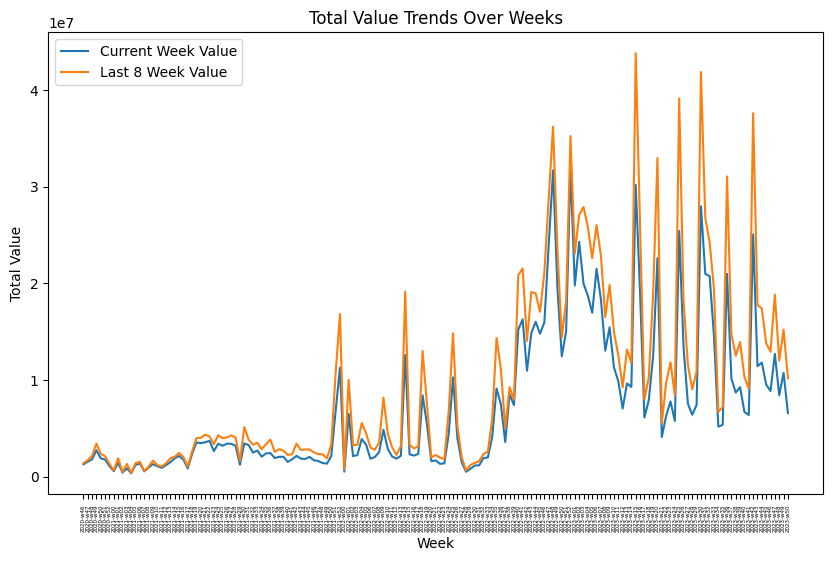

In [64]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Total_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Total Value')
plt.title('Total Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

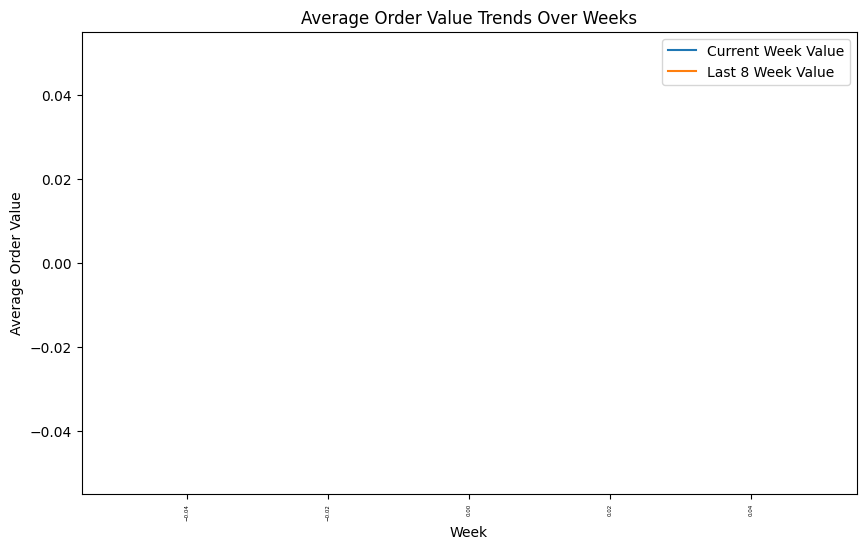

In [65]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Average_Order_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Average Order Value')
plt.title('Average Order Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

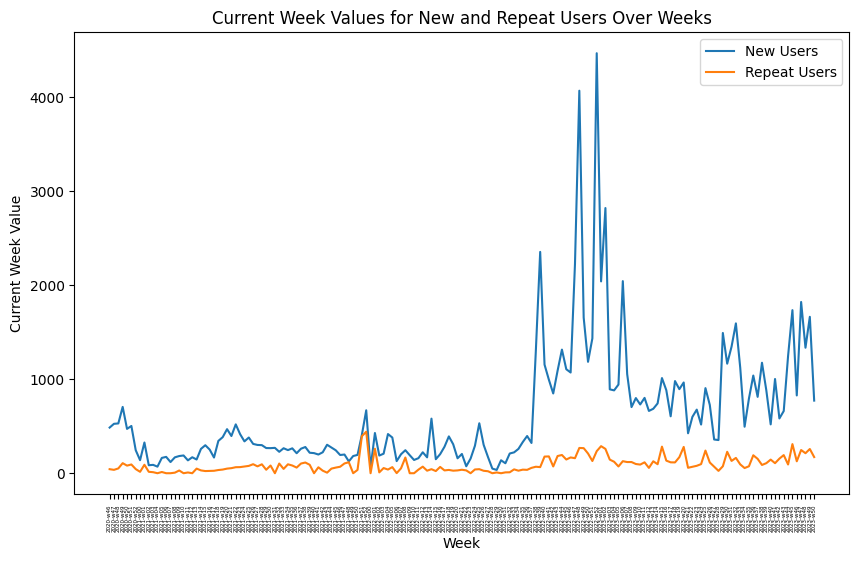

In [66]:
import matplotlib.pyplot as plt

# Filter for 'No_of_New_Users(First_Time_Users)'
new_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_New_Users(First_Time_Users)']

# Filter for 'No_of_Repeat_Users'
repeat_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value' for New Users
plt.plot(new_users_rows['WeekCount'], new_users_rows['Current Week Value'], label='New Users')

# Plot 'WeekCount' versus 'Current Week Value' for Repeat Users
plt.plot(repeat_users_rows['WeekCount'], repeat_users_rows['Current Week Value'], label='Repeat Users')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Current Week Value')
plt.title('Current Week Values for New and Repeat Users Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()


In [67]:
# total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']
# # Plot the graph
# plt.figure(figsize=(10, 6))

# # Plot 'WeekCount' versus 'Current Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# # Plot 'WeekCount' versus 'Last 8 Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# # Set labels and title
# plt.xlabel('Week')
# plt.ylabel('No_of_Repeat_Users')
# plt.title('No_of_Repeat_Users Trends Over Weeks')
# plt.xticks(rotation=90, fontsize=4)
# plt.legend()

# # Show the plot
# plt.show()

In [68]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Lables,Product_Cohort_Lables
0,2020-w46,Churned (Repeat Use)-New Business Drivers,0.0,0.000000e+00,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers
1,2020-w46,Champions-Repeat Business Drivers,68362.0,3.037567e+04,Secondary_Explanatory,Champions,Repeat Business Drivers
2,2020-w46,Churned (Repeat Use)-Hero,8248.0,3.987225e+04,Secondary_Explanatory,Churned (Repeat Use),Hero
3,2020-w46,Churned (Repeat Use)-High Value & Slow Moving,3198.0,3.354740e+04,Secondary_Explanatory,Churned (Repeat Use),High Value & Slow Moving
4,2020-w46,Churned (Repeat Use)-Low Value & Slow Moving,7598.0,2.848917e+04,Secondary_Explanatory,Churned (Repeat Use),Low Value & Slow Moving
...,...,...,...,...,...,...,...
4880,2023-w50,Champions-High Value & Slow Moving,680304.0,1.372064e+06,Secondary_Explanatory,Champions,High Value & Slow Moving
4881,2023-w50,Champions-Hero,1372064.0,0.000000e+00,Secondary_Explanatory,Champions,Hero
4886,2023-w50,Churned (Single Use Only)-New Business Drivers,0.0,1.002166e+05,Secondary_Explanatory,Churned (Single Use Only),New Business Drivers
4888,2023-w50,Churned (Repeat Use)-New Business Drivers,9810.0,5.138222e+05,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers


In [69]:
# # Group the data by Product Cohort Labels
# grouped_data = new_df_1.groupby('Product_Cohort_Lables')

# # Plot the data for each Product Cohort Label
# plt.figure(figsize=(12, 8))

# for label, group in grouped_data:
#     plt.plot(group['WeekCount'], group['Current Week Value'], label=label)

# plt.xlabel('Week Count')
# plt.ylabel('Current Week Value')
# plt.title('Current Week Value for Each Product Cohort Label')
# plt.legend(title='Product Cohort Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

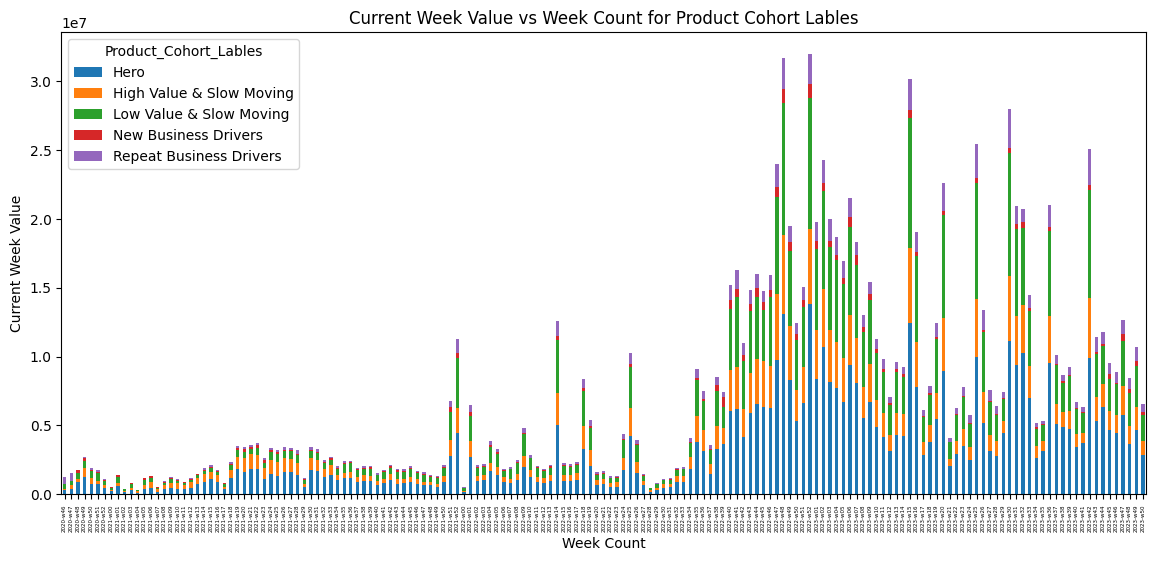

In [70]:
df_agg = new_df_1.groupby(['WeekCount', 'Product_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df = df_agg.pivot(index='WeekCount', columns='Product_Cohort_Lables', values='Current Week Value')
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for Product Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax.tick_params(axis='x', labelsize=4)
plt.show()

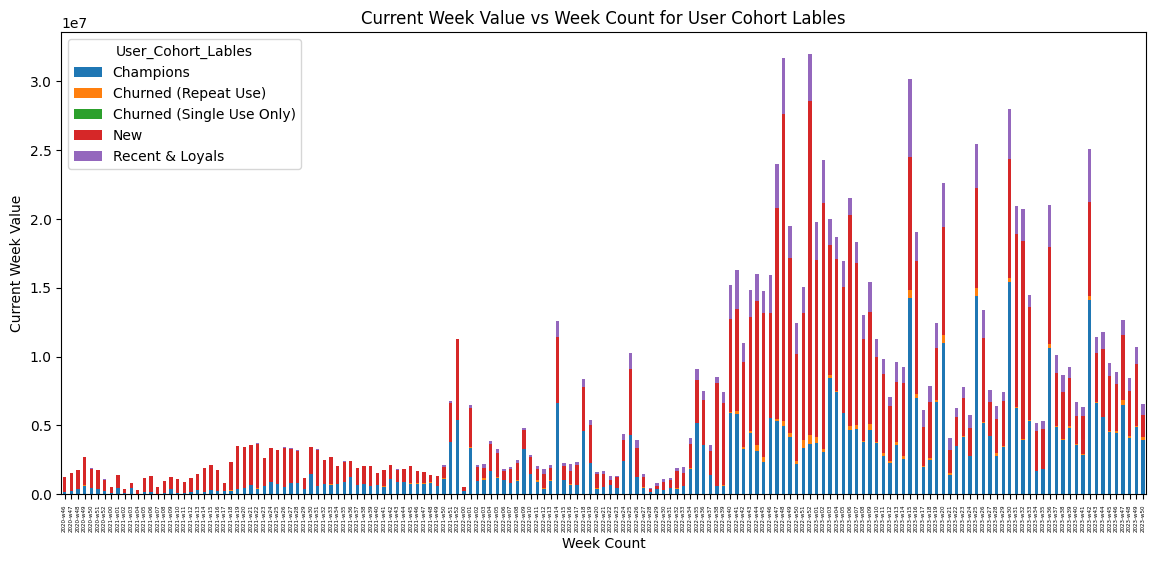

In [71]:
df_agg_user = new_df_1.groupby(['WeekCount', 'User_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df_user = df_agg_user.pivot(index='WeekCount', columns='User_Cohort_Lables', values='Current Week Value')
ax_user = pivot_df_user.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for User Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax_user.tick_params(axis='x', labelsize=4)
plt.show()